# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки:**  
DateCrawled — дата скачивания анкеты из базы   
VehicleType — тип автомобильного кузова   
RegistrationYear — год регистрации автомобиля   
Gearbox — тип коробки передач   
Power — мощность (л. с.)   
Model — модель автомобиля   
Kilometer — пробег (км)   
RegistrationMonth — месяц регистрации автомобиля   
FuelType — тип топлива   
Brand — марка автомобиля   
NotRepaired — была машина в ремонте или нет   
DateCreated — дата создания анкеты   
NumberOfPictures — количество фотографий автомобиля   
PostalCode — почтовый индекс владельца анкеты (пользователя)   
LastSeen — дата последней активности пользователя   
   
**Целевой признак:**   
Price — цена (евро)

## Подготовка данных

In [3]:
import pandas as pd
import os.path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from catboost import CatBoostRegressor
import numpy as np
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 29)
file_name = 'autos.csv'
local_path = os.path.join('G:', os.sep, 'Мой диск', 'Data Science', 'Проекты', '11 Продажи авто', 'data')
web_dir_path = os.path.join(os.sep, 'datasets' + os.sep)
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [4]:
try:
    data_full  = pd.read_csv(web_dir_path + file_name)
except FileNotFoundError:
    data_full = pd.read_csv(local_path + file_name)
else:
    print(f'Общая информация о данных датасета ', file_name, ':', '\n', sep='')
    data_full.info()
    print(f'\nОбзор данных датасета ', file_name, ':', sep='')
    display(data_full)

Общая информация о данных датасета autos.csv:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           35

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [5]:
data_full['DateCrawled'] = pd.to_datetime(data_full['DateCrawled'])
data_full['DateCreated'] = pd.to_datetime(data_full['DateCreated'])
data_full['LastSeen'] = pd.to_datetime(data_full['LastSeen'])
print(f'Минимальные значения в данных датасета:')
display(data_full.min())
print(f'Максимальные значения в данных датасета:')
display(data_full.max())
data = data_full.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'NumberOfPictures', 'LastSeen', 'RegistrationMonth'], axis=1)
display(data)

Минимальные значения в данных датасета:


DateCrawled          2016-03-05 14:06:22
Price                                  0
RegistrationYear                    1000
Power                                  0
Kilometer                           5000
RegistrationMonth                      0
Brand                         alfa_romeo
DateCreated          2014-03-10 00:00:00
NumberOfPictures                       0
PostalCode                          1067
LastSeen             2016-03-05 14:15:08
dtype: object

Максимальные значения в данных датасета:


DateCrawled          2016-04-07 14:36:58
Price                              20000
RegistrationYear                    9999
Power                              20000
Kilometer                         150000
RegistrationMonth                     12
Brand                              volvo
DateCreated          2016-04-07 00:00:00
NumberOfPictures                       0
PostalCode                         99998
LastSeen             2016-04-07 14:58:51
dtype: object

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Заполним пропуски в NotRepaired значением 'yes', т.к. пропуск здесь означает отсутствие сведений о ремонте ТС, что равносильно значению 'yes' других записей этого столбца. Пропуски в других столбцах заполняем 'other', т.к. аналогичная категория уже содержится в датасете и она также означает не соотвествие имеющимся категориям. Удаляем полные дубликаты, так как их наличие не оказывает положительного влияния на качество результатов моделей.

In [6]:
print(f'Колонки с пропущенными значениями в данных датасета:')
display(data.isna().sum())
data['NotRepaired'].fillna(value='yes', inplace=True)
data.fillna(value='other', inplace=True)
print(f'Количество дубликатов в данных датасета:')
print(data.duplicated().sum(), ' - ', round(data.duplicated().sum()/len(data) * 100, 2), '%\n')
data = data.drop_duplicates()
print(f'Доля удалённых из датасета данных:')
print(round((1 - data.size/data_full.size) * 100, 2), '%\n')
print(f'Доля удалённых из датасета строк:')
print(round((1 - data.shape[0]/data_full.shape[0]) * 100, 2), '%\n')
display(data)

Колонки с пропущенными значениями в данных датасета:


Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
NotRepaired         71154
dtype: int64

Количество дубликатов в данных датасета:
46915  -  13.24 %

Доля удалённых из датасета данных:
45.77 %

Доля удалённых из датасета строк:
13.24 %



,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,yes
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,yes
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,other,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,other,2005,other,0,other,20000,other,sonstige_autos,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Посмотрим корреляцию данных.


Корреляция данных датасета:


,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.025515,0.146914,-0.324512
RegistrationYear,0.025515,1.000000,-0.000951,-0.052473
Power,0.146914,-0.000951,1.000000,0.026911
Kilometer,-0.324512,-0.052473,0.026911,1.000000


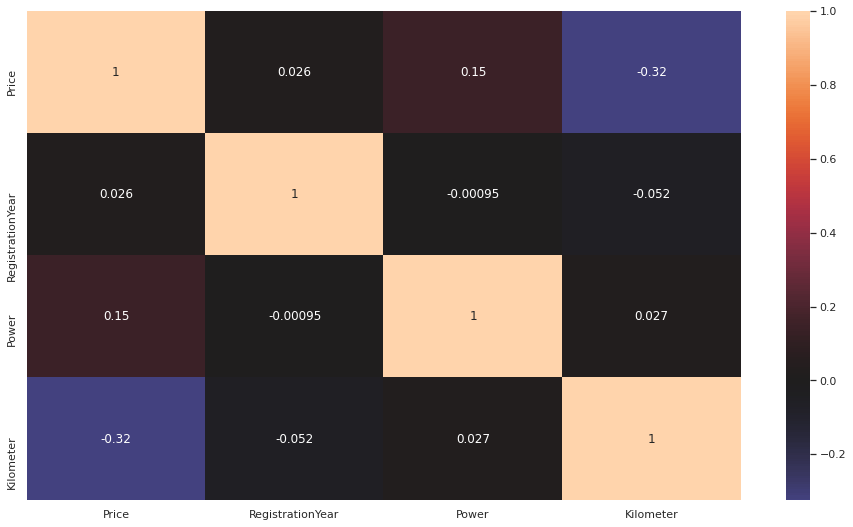

In [7]:
print(f'\nКорреляция данных датасета:')
display(data.corr())
sns.set(rc = {'figure.figsize':(16,9)})
ax = sns.heatmap(data.corr(), center=0, annot=True)

Наибольшую корреляцию видим между данными Price и Power/RegistrationYear. Уберём строки с 0-ми значениями из столбцов Power и Price, RegistrationYear свыше 2016 года (максимальный год скачивания анкеты из базы данных) - эти данные, очевидно, являются ошибочными.

In [8]:
data = data[(data['Price'] > 0) & (data['Power'] > 0) & (data['RegistrationYear'] < 2016)]

Посмотрим распределение данных в столбцах Price и RegistrationYear.

In [9]:
display(data[['Power', 'RegistrationYear']].describe())
display(data[data['Power'] > 500]['Power'].describe())
display(data[data['Power'] > 500])
display(data[data['RegistrationYear'] < 1940]['RegistrationYear'].describe())
display(data[data['RegistrationYear'] < 1940])

,Power,RegistrationYear
count,250421.000000,250421.000000
mean,126.189980,2002.527683
std,199.590096,8.487361
min,1.000000,1000.000000
25%,80.000000,1999.000000
50%,115.000000,2003.000000
75%,150.000000,2007.000000
max,20000.000000,2015.000000


count      374.000000
mean      2935.104278
std       4107.295882
min        504.000000
25%        782.000000
50%       1390.000000
75%       2004.750000
max      20000.000000
Name: Power, dtype: float64

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,yes
6296,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,yes
...,...,...,...,...,...,...,...,...,...,...
348830,1,other,1000,other,1000,other,150000,other,sonstige_autos,yes
348883,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,yes
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no


count      45.000000
mean     1751.555556
std       332.682729
min      1000.000000
25%      1800.000000
50%      1927.000000
75%      1935.000000
max      1938.000000
Name: RegistrationYear, dtype: float64

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
18224,7999,other,1500,manual,224,impreza,5000,other,subaru,yes
22621,14000,sedan,1929,manual,30,other,5000,petrol,sonstige_autos,yes
23750,3900,wagon,1910,manual,90,passat,150000,petrol,volkswagen,yes
34055,2900,small,1937,manual,34,other,40000,petrol,ford,yes
34332,450,other,1800,other,1800,other,5000,other,mitsubishi,no
38875,1234,other,1234,other,26,other,5000,other,trabant,yes
56241,950,other,1400,manual,1400,golf,125000,petrol,volkswagen,yes
62803,3400,small,1910,manual,90,beetle,90000,other,volkswagen,no
68185,19900,convertible,1932,manual,18,other,5000,petrol,bmw,no
74814,400,other,1910,other,60,golf,150000,petrol,volkswagen,yes


Посмотрим выбросы методом 1,5 IQR по столбцам Power, RegistrationYear. Делаем данное действие т.к. исходя из минимальных и максимальных значений этих столбцов, распределения данных и осмотра данных они, очевидно, содержат ошибочные данные наравне с данными редких ТС. Исходя из заданного заказчиком критерия качества моделей и в целях сохранения данных о редких ТС, убрали данные от 500 л.с. и до 1940-го года регистрации ТС.

Граница "верхнего уса ящика" колонки Power = 255 л.с. 
Граница "нижнего уса ящика" колонки Power = 0

Количество удалённых строк данных от 500 л.с. ТС:
0.14934849713083168  %


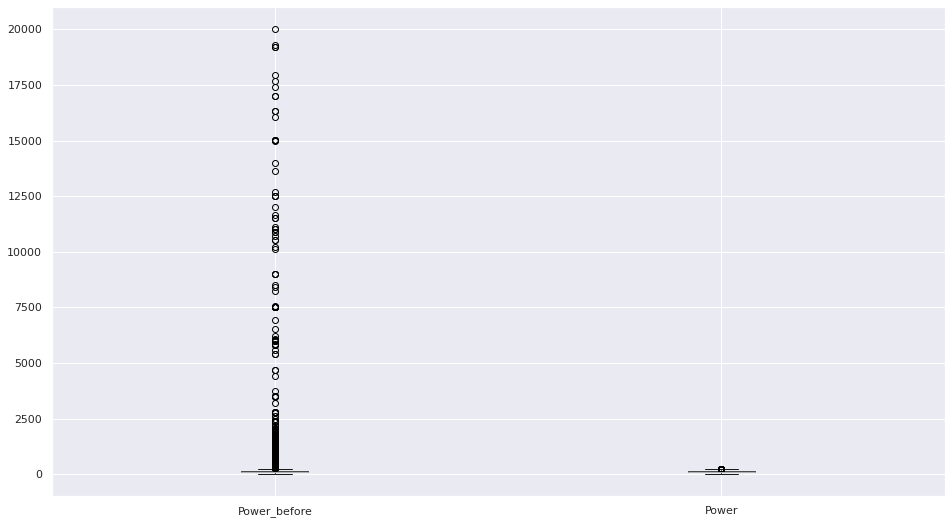

In [10]:
temp_data = pd.DataFrame({'Power_before': data['Power'].copy()})
q25, q75 = np.percentile(data['Power'], [25, 75])
IQR = q75 - q25
max_ = round(q75+(1.5*IQR), 0)
min_ = round(q25-(1.5*IQR), 0)
print(f'Граница "верхнего уса ящика" колонки Power = {max_:g} л.с. ') if max_ < data['Power'].max() else print('Граница "верхнего уса ящика" колонки Power = максимальному значению')
print(f'Граница "нижнего уса ящика" колонки Power = {min_:g} л.с.\n') if min_ > 0 else print('Граница "нижнего уса ящика" колонки Power = 0\n')
print('Количество удалённых строк данных от 500 л.с. ТС:')
print(len(data[data['Power'] > 500])/len(data)*100, ' %')
boxplot = pd.concat([temp_data, data.loc[(data['Power'] >= min_)&(data['Power'] <= max_), 'Power']], axis=1).boxplot(figsize=(16, 9));
data = data.loc[(data['Power'] >= 0)&(data['Power'] <= 500)]

Граница "верхнего уса ящика" колонки RegistrationYear = максимальному значению
Граница "нижнего уса ящика" колонки RegistrationYear = 1987

Количество удалённых строк данных в пределах до 1940 гг регистрации ТС:
0.01519714293712782  %


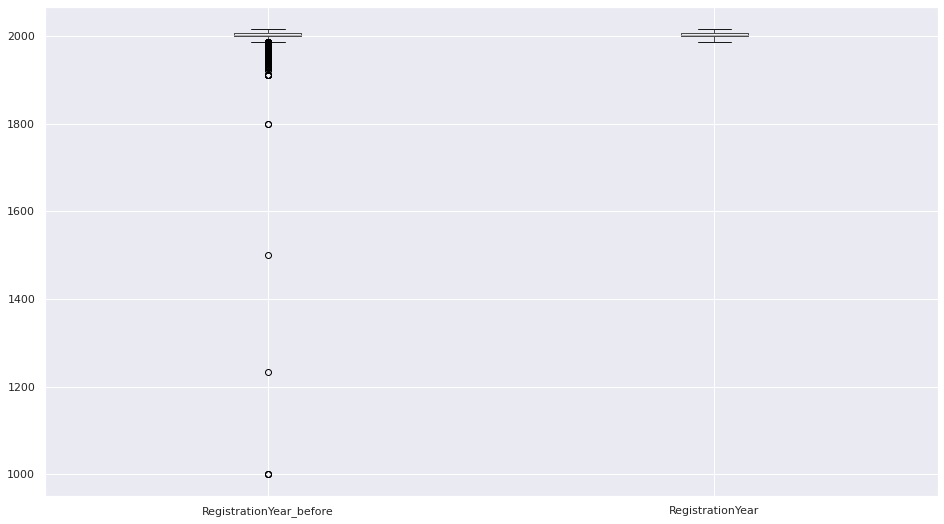

In [11]:
temp_data = pd.DataFrame({'RegistrationYear_before': data['RegistrationYear'].copy()})
q25, q75 = np.percentile(data['RegistrationYear'], [25, 75])
IQR = q75 - q25
max_ = round(q75+(1.5*IQR), 0)
min_ = round(q25-(1.5*IQR), 0)
print(f'Граница "верхнего уса ящика" колонки RegistrationYear = {max_:g} ') if max_ < data['RegistrationYear'].max() else print('Граница "верхнего уса ящика" колонки RegistrationYear = максимальному значению')
print(f'Граница "нижнего уса ящика" колонки RegistrationYear = {min_:g}\n') if min_ > 0 else print('Граница "нижнего уса ящика" колонки RegistrationYear = 0\n')
print('Количество удалённых строк данных в пределах до 1940 гг регистрации ТС:')
print(len(data[data['RegistrationYear'] < 1940])/len(data)*100, ' %')
boxplot = pd.concat([temp_data, data.loc[(data['RegistrationYear'] >= min_)&(data['RegistrationYear'] <= max_), 'RegistrationYear']], axis=1).boxplot(figsize=(16, 9));
data = data.loc[data['RegistrationYear'] >= 1940]

Масштабируем числовые данные.

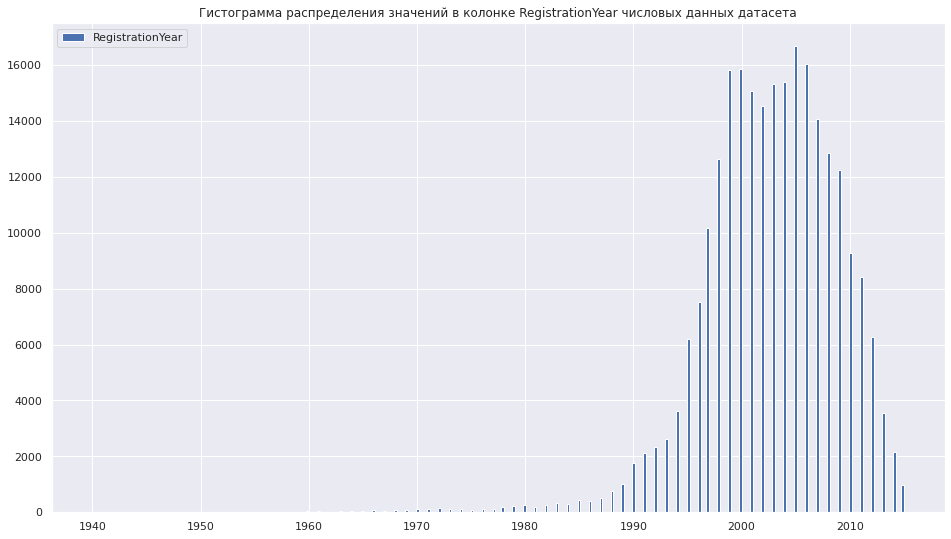

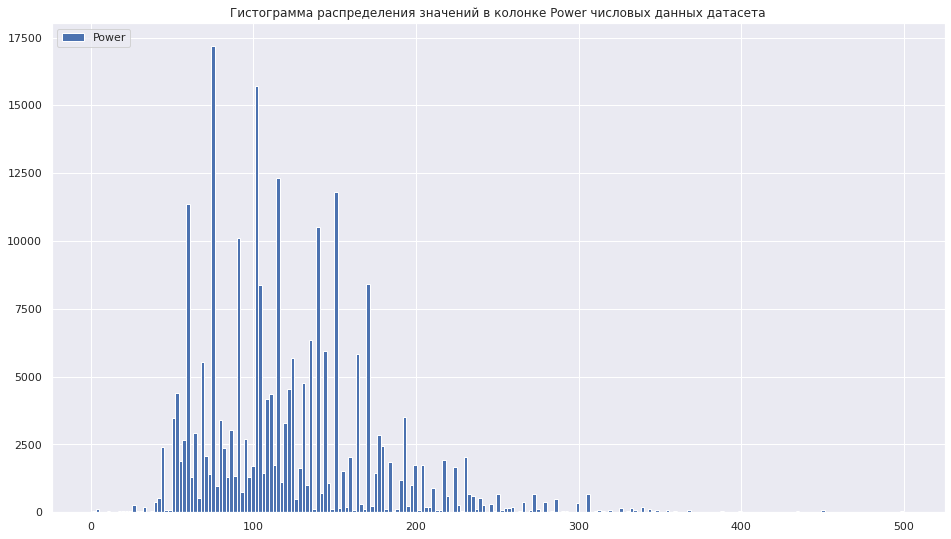

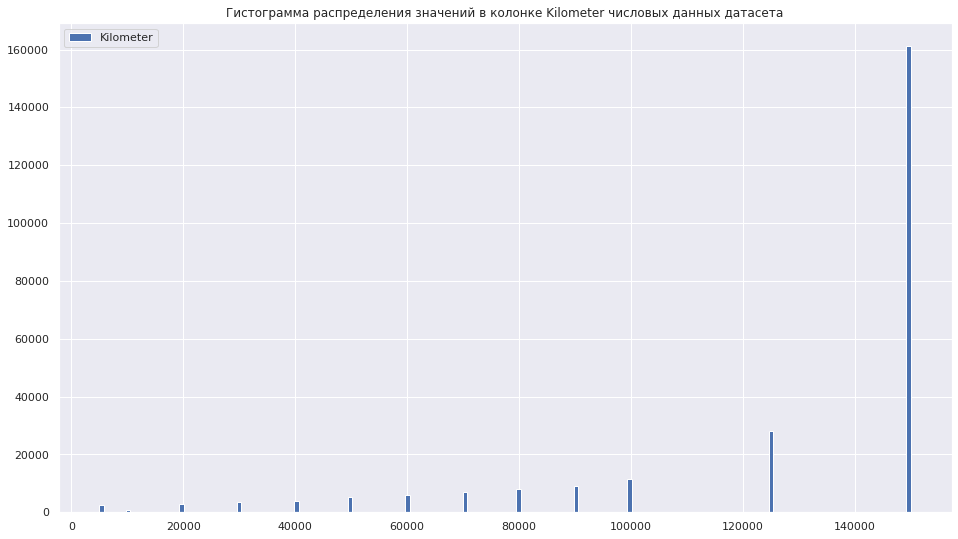

In [12]:
data_numeric = data.select_dtypes('int64').drop('Price', axis=1).copy()
# data_numeric.info()
# scaler = StandardScaler()
# scaler.fit(data_numeric)
# data[data_numeric.columns] = scaler.transform(data_numeric)
# display(data)
for col in data_numeric.columns:
    plt.figure(figsize=(16, 9))
    data_qntl = data_numeric[col]
    q25, q75 = np.percentile(data_qntl, [25, 75])
    bin_width = 2 * (q75 - q25) * len(data_qntl) ** (-1/3)
    bins = round((data_qntl.max() - data_qntl.min()) / bin_width)
    plt.hist(data_qntl, bins = 'fd', alpha = 1, label=col)
    plt.legend(loc='upper left')
    plt.title(f'Гистограмма распределения значений в колонке {col} числовых данных датасета')
    plt.show()

По гистограммам видим, что данные имеют приближенные к нормальным распределения, однако данные о пробеге категоризированы округлёнными значениями и такого распределения не демонстрируют, вместе с тем имеют значительный коэффициент отрицательной корелляции со стоимостью ТС.

Преобразуем прямым кодированием категориальные признаки в машиночитаемые столбцы из 0 и 1

In [13]:
data_ohe = pd.get_dummies(data, drop_first=True)
display(data_ohe)

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Gearbox_other,Model_145,...,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
1,18300,2011,190,125000,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1500,2001,75,150000,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,3999,2005,3,150000,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
354362,3200,2004,225,150000,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1
354366,1199,2000,101,125000,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0
354367,9200,1996,102,150000,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [14]:
target_ohe = data_ohe['Price']
features_ohe = data_ohe.drop('Price', axis=1)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe, target_ohe, test_size = 0.25, 
                                                                                                 random_state = 12345)
#display(features_train_ohe)
features_train_ohe_numeric = features_train_ohe.select_dtypes('int64').copy()#.drop('Price', axis=1).copy()
features_train_ohe_numeric.info()
scaler = StandardScaler()
scaler.fit(features_train_ohe_numeric)
features_train_ohe.loc[:, features_train_ohe_numeric.columns] = scaler.transform(features_train_ohe_numeric)
display(features_train_ohe)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187506 entries, 25250 to 303246
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   RegistrationYear  187506 non-null  int64
 1   Power             187506 non-null  int64
 2   Kilometer         187506 non-null  int64
dtypes: int64(3)
memory usage: 5.7 MB


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Gearbox_other,Model_145,Model_147,...,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
25250,-1.174976,-1.334510,0.612601,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0
312249,-0.242956,-0.871015,0.612601,0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0
128844,-0.553629,-1.149112,0.612601,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1
48859,-0.398292,0.055977,0.612601,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0
72810,-0.087619,0.519472,0.612601,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110660,0.533728,-0.036722,-0.053846,1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1
177197,0.689065,-0.778315,0.612601,0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0
173101,-1.174976,-0.222121,-3.252791,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99575,0.999739,-0.778315,0.612601,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [15]:
data[data.select_dtypes('object').columns] = data.select_dtypes('object').astype('category')
target = data['Price']
features = data.drop('Price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.25, 
                                                                                                 random_state = 12345)
features_train_numeric = features_train.select_dtypes('int64').copy()#.drop('Price', axis=1).copy()
features_train_numeric.info()
#scaler = StandardScaler()
scaler.fit(features_train_numeric)
features_train.loc[:, features_train_numeric.columns] = scaler.transform(features_train_numeric)
display(features_train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187506 entries, 25250 to 303246
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   RegistrationYear  187506 non-null  int64
 1   Power             187506 non-null  int64
 2   Kilometer         187506 non-null  int64
dtypes: int64(3)
memory usage: 5.7 MB


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
25250,small,-1.174976,manual,-1.334510,polo,0.612601,petrol,volkswagen,no
312249,wagon,-0.242956,manual,-0.871015,fabia,0.612601,petrol,skoda,no
128844,small,-0.553629,manual,-1.149112,ibiza,0.612601,petrol,seat,yes
48859,small,-0.398292,manual,0.055977,golf,0.612601,other,volkswagen,no
72810,wagon,-0.087619,auto,0.519472,3er,0.612601,gasoline,bmw,no
...,...,...,...,...,...,...,...,...,...
110660,convertible,0.533728,manual,-0.036722,mx_reihe,-0.053846,petrol,mazda,yes
177197,wagon,0.689065,manual,-0.778315,fabia,0.612601,petrol,skoda,no
173101,sedan,-1.174976,manual,-0.222121,other,-3.252791,petrol,bmw,no
99575,sedan,0.999739,manual,-0.778315,golf,0.612601,petrol,volkswagen,no


## Обучение моделей

Посчитаем модель RandomForestRegressor

In [31]:
param_dist_forest = {"max_depth": [3, None],
                  "max_features": sp_randint(1, 11),
                  "min_samples_split": sp_randint(2, 11),}

random_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist_forest,
                                       n_iter=3, scoring='neg_root_mean_squared_error', random_state = 54321)

In [32]:
random_search.fit(features_train_ohe, target_train_ohe)
best_model_forest_est = random_search.best_estimator_
print(f'Параметры лучшей модели RandomForestRegressor по метрике RMSE: {best_model_forest_est}')

Параметры лучшей модели RandomForestRegressor по метрике RMSE: RandomForestRegressor(max_features=8)


In [33]:
%%time
best_model_forest = best_model_forest_est.fit(features_train_ohe, target_train_ohe)

CPU times: user 1min 37s, sys: 1.16 s, total: 1min 38s
Wall time: 1min 38s


In [34]:
%%time
predicted = best_model_forest.predict(features_train_ohe)

CPU times: user 10.4 s, sys: 180 ms, total: 10.6 s
Wall time: 10.6 s


In [35]:
scores_forest = cross_val_score(best_model_forest, features_train_ohe, target_train_ohe, scoring='neg_root_mean_squared_error', cv=5)
rmse_forest = abs(scores_forest.mean())
print(f'Лучшее значение RMSE для RandomForestRegressor: {rmse_forest}')

Лучшее значение RMSE для RandomForestRegressor: 1709.875379654645


Посчитаем модель LGBMRegressor

In [17]:
param_dist_lgbm = {'boosting_type': ['gbdt'],
                   'objective': ['regression'],
                   'metric': ['rmse'],
                   'max_depth': [6], 
                   'learning_rate': [0.1],
                   'verbose': [10],
                  }
random_search = RandomizedSearchCV(LGBMRegressor(), param_distributions = param_dist_lgbm, n_iter = 3, scoring='neg_mean_absolute_error', random_state=54321, n_jobs = 18)

In [18]:
random_search.fit(features_train, target_train)
best_model_lgbm_est = random_search.best_estimator_
print(f'Параметры лучшей модели LGBMRegressor по метрике RMSE: {best_model_lgbm_est}')

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.763685
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.181272
[LightGBM] [Debug] init for col-wise cost 0.002944 seconds, init for row-wise cost 0.003681 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 187506, number of used features: 9
[LightGBM] [Info] Start training from score 5006.257320
[LightGBM] [Debug] Trained 

In [19]:
%%time
best_model_lgbm = best_model_lgbm_est.fit(features_train, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.763685
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.181272
[LightGBM] [Debug] init for col-wise cost 0.089800 seconds, init for row-wise cost 0.003651 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 187506, number of used features: 9
[LightGBM] [Info] Start training from score 5006.257320
[LightGBM] [Debug] Trained 

In [39]:
%%time
predicted = best_model_lgbm.predict(features_train)

CPU times: user 1.76 s, sys: 0 ns, total: 1.76 s
Wall time: 1.81 s


In [40]:
scores_lgbm = cross_val_score(best_model_lgbm, features_train, target_train, scoring='neg_root_mean_squared_error', cv=5)
rmse_lgbm = abs(scores_lgbm.mean())
print(f'Лучшее значение RMSE для LGBMRegressor: {rmse_lgbm}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.763016
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.181196
[LightGBM] [Debug] init for col-wise cost 0.091148 seconds, init for row-wise cost 0.002902 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 150004, number of used features: 9
[LightGBM] [Info] Start training from score 5011.730094
[LightGBM] [Debug] Trained 

Посчитаем модель CatBoostRegressor

In [41]:
param_dist_cbr = {'learning_rate': [0.03, 0.1],
                  'depth': [6, 10],
                  'l2_leaf_reg': [3, 5, 7, 9],
                  'has_time': [True],
                  'loss_function':'RMSE'
                  }
param_dist_cbr = {'depth'         : [6,8,10],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations'    : [30, 50, 100]
                 }
cbr = CatBoostRegressor(loss_function="RMSE", iterations=20, depth=10, verbose=10, cat_features=data.select_dtypes('category').columns.to_list())
random_search = RandomizedSearchCV(cbr, param_distributions = param_dist_cbr, cv = 2, n_jobs=-1)

In [42]:
random_search.fit(features_train, target_train)
best_model_cbr_est = random_search.best_estimator_
print(f'Параметры лучшей модели CatBoostRegressor по метрике RMSE: {best_model_cbr_est}')

0:	learn: 4641.2107732	total: 86ms	remaining: 8.51s
10:	learn: 4342.5354594	total: 372ms	remaining: 3.01s
20:	learn: 4077.1933798	total: 644ms	remaining: 2.42s
30:	learn: 3843.3425893	total: 928ms	remaining: 2.06s
40:	learn: 3635.4052139	total: 1.21s	remaining: 1.74s
50:	learn: 3451.6056100	total: 1.49s	remaining: 1.43s
60:	learn: 3288.6665160	total: 1.76s	remaining: 1.13s
70:	learn: 3144.8398007	total: 2.04s	remaining: 834ms
80:	learn: 3018.3132904	total: 2.31s	remaining: 542ms
90:	learn: 2904.9430467	total: 2.6s	remaining: 258ms
99:	learn: 2814.7711912	total: 2.85s	remaining: 0us
0:	learn: 4633.5821901	total: 32.7ms	remaining: 3.24s
10:	learn: 4337.9500500	total: 314ms	remaining: 2.54s
20:	learn: 4075.3060369	total: 585ms	remaining: 2.2s
30:	learn: 3843.2193177	total: 859ms	remaining: 1.91s
40:	learn: 3637.0005601	total: 1.13s	remaining: 1.63s
50:	learn: 3454.7622256	total: 1.41s	remaining: 1.35s
60:	learn: 3291.5869485	total: 1.68s	remaining: 1.07s
70:	learn: 3148.8048868	total: 1.9

In [43]:
%%time
best_model_cbr = best_model_cbr_est.fit(features_train, target_train)

0:	learn: 4330.7182423	total: 106ms	remaining: 5.18s
10:	learn: 2535.8959283	total: 1.03s	remaining: 3.65s
20:	learn: 2003.0913560	total: 1.9s	remaining: 2.62s
30:	learn: 1835.0921529	total: 2.77s	remaining: 1.7s
40:	learn: 1767.3982202	total: 3.63s	remaining: 797ms
49:	learn: 1734.3631596	total: 4.47s	remaining: 0us
CPU times: user 4.59 s, sys: 47.6 ms, total: 4.64 s
Wall time: 5.24 s


In [44]:
%%time
predicted = best_model_cbr.predict(features_train)

CPU times: user 123 ms, sys: 4.03 ms, total: 127 ms
Wall time: 124 ms


In [45]:
scores_cbr = cross_val_score(best_model_cbr, features_train, target_train, scoring='neg_root_mean_squared_error', cv=5)
rmse_cbr = abs(scores_cbr.mean())
print(f'Лучшее значение RMSE для CatBoostRegressor: {rmse_cbr}')

0:	learn: 4328.8602639	total: 80.7ms	remaining: 3.95s
10:	learn: 2549.2079231	total: 807ms	remaining: 2.86s
20:	learn: 1997.4815903	total: 1.52s	remaining: 2.11s
30:	learn: 1833.2588540	total: 2.25s	remaining: 1.38s
40:	learn: 1766.0396352	total: 2.96s	remaining: 649ms
49:	learn: 1735.8346940	total: 3.62s	remaining: 0us
0:	learn: 4330.0335342	total: 80.4ms	remaining: 3.94s
10:	learn: 2535.6670414	total: 843ms	remaining: 2.99s
20:	learn: 1997.5668476	total: 1.55s	remaining: 2.14s
30:	learn: 1839.6222197	total: 2.28s	remaining: 1.4s
40:	learn: 1774.6825527	total: 3.01s	remaining: 661ms
49:	learn: 1742.0419924	total: 3.66s	remaining: 0us
0:	learn: 4325.5443554	total: 82ms	remaining: 4.02s
10:	learn: 2522.1660237	total: 807ms	remaining: 2.86s
20:	learn: 1998.2733549	total: 1.52s	remaining: 2.1s
30:	learn: 1836.7803015	total: 2.25s	remaining: 1.38s
40:	learn: 1766.1526197	total: 2.97s	remaining: 653ms
49:	learn: 1732.5313578	total: 3.62s	remaining: 0us
0:	learn: 4328.4039256	total: 79.9ms	r

In [27]:
results = pd.DataFrame(np.array([[1709.87, 1658.48, 1767.01], [98, 4.31, 5.24], [10.6, 1.81, 0.124]]),
                   columns=['RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor'],
                      index = ['rmse', 'fit_time, sec', 'predict_time, sec'])
results


,RandomForestRegressor,LGBMRegressor,CatBoostRegressor
rmse,1709.87,1658.48,1767.010
"fit_time, sec",98.00,4.31,5.240
"predict_time, sec",10.60,1.81,0.124


## Анализ моделей

Таким образом, лучшую метрику RMSE показала модель LGBMRegressor, однако время обучения и предсказания у CatBoostRegressor на одной и той же конфигурации оборудования лучше.

Проверим лучшую модель на тестовой выборке и посчитаем метрику RMSE кросс-валидацией и прямым способом.

In [20]:
scores_lgbm = cross_val_score(best_model_lgbm, features_test, target_test, scoring='neg_root_mean_squared_error', cv=5)
rmse_lgbm = abs(scores_lgbm.mean())
print(f'Лучшее значение RMSE для LGBMRegressor: {rmse_lgbm}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.764079
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.181231
[LightGBM] [Debug] init for col-wise cost 0.005109 seconds, init for row-wise cost 0.001034 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 50002, number of used features: 9
[LightGBM] [Info] Start training from score 5043.582497
[LightGBM] [Debug] Trained a

In [23]:
features_test_numeric = features_test.select_dtypes('int64').copy()
features_test_numeric.info()
scaler.fit(features_test_numeric)
features_test.loc[:, features_test_numeric.columns] = scaler.transform(features_test_numeric)
display(features_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62503 entries, 11067 to 131553
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   RegistrationYear  62503 non-null  int64
 1   Power             62503 non-null  int64
 2   Kilometer         62503 non-null  int64
dtypes: int64(3)
memory usage: 1.9 MB


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
11067,sedan,0.375081,manual,0.517652,superb,0.616730,petrol,skoda,no
52020,sedan,-1.192724,auto,-0.000938,c_klasse,-1.512184,petrol,mercedes_benz,no
338510,sedan,-1.035943,manual,-0.593612,6_reihe,0.616730,petrol,mazda,no
153132,sedan,-2.133407,manual,-0.445443,golf,0.616730,petrol,volkswagen,no
213640,small,0.375081,auto,-0.204670,modus,-0.713842,petrol,renault,no
...,...,...,...,...,...,...,...,...,...
298138,sedan,0.061520,manual,-0.112064,3er,-0.048556,petrol,bmw,no
45926,sedan,1.315764,manual,-0.315796,golf,-0.048556,other,volkswagen,no
351632,bus,-3.857993,auto,-0.778822,other,0.616730,petrol,sonstige_autos,yes
264732,convertible,1.002203,manual,1.147368,clk,-1.778299,petrol,mercedes_benz,no


In [24]:
%%time
predicted = best_model_lgbm.predict(features_test)


CPU times: user 606 ms, sys: 0 ns, total: 606 ms
Wall time: 586 ms


In [25]:
display(mean_squared_error(target_test,predicted,squared=False))

1644.44439649256

Таким образом, нами проверена лучшая из рассмотренных моделей, а именно LGBMRegressor. Метрика RMSE, использованная по условиям задания, показала на текстовой выборке схожие с трейн-выборкой результаты, т.е. окончательная проверка подтвердила работоспособность маодели, корректность препроцессинга данных и обучения модели. По способности к анализу категориальных данных, преимуществ какой-либо из бустинг-моделей не обнаружил.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей